In [13]:
#!pip install SALib tqdm joblib
from joblib import Parallel, delayed
import numpy as np
from scipy.integrate import odeint
from SALib.sample import sobol
from tqdm import tqdm
import scipy

In [14]:
def enzymic_amox(t,y, 
kcat1,
kcat2,
Km1,
Km2,  
Tmax, 
Ken,  
kAB,  
kAN,  
kAOH, 
kNH):
    FAB = 0
    FNH = 0 
    
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    Cez = 1

    # Consumo de ester
    VAB = (kcat1*CAB*Cez)/((Km1*(1 + (CAN/kAN) + (CAOH/kAOH))) + CAB)
    
    # Hidrolise de amoxicilina
    VAN = (kcat2*CAN*Cez)/((Km2*(1 + (CAB/kAB) + (CNH/kNH) + (CAOH/kAOH))) + CAN)
    
    # Enzima saturada com 6-apa
    X   = CNH/(Ken + CNH)
    
    # Sintese enzimatica
    VS  = VAB*Tmax*X

    # Hidrolise de ester
    Vh1 = (VAB - VS) 

    dy = np.zeros(4)

    # C. ester
    dy[0] = ((-(VS - VAN) - (Vh1 + VAN)) + FAB) 
    
    # C. amox
    dy[1] = (VS - VAN)                         
    
    # C. 6-apa
    dy[2] = (-(VS - VAN) + FNH)                
    
    # C. POHPG
    dy[3] =  (Vh1 + VAN)
    
    return np.array(dy)      

In [15]:
Cez = 1

k2 = 187 / 60             # 1/min             
k3 = 44 / 60              # 1/min            
k4 = 235 / 60             # 1/min            
k5 = 0.15                 # 1/min            
KS = 380                  # milimolar            
KP = 95                   # milimolar            
KN = 43                   # milimolar            
kmenos4 = 217 / 60        # 1/min         

P_mcd = [k2,k3,k4,k5,KS,KP,KN,kmenos4]

Np_mcd = len(P_mcd)
print(P_mcd)

In [16]:
def ode15s_amox(P, CI, t):
    return scipy.integrate.solve_ivp(enzymic_amox,t_span=(t[0],t[-1]),t_eval=t,y0=CI,method='RK45',args=P).y.T

In [17]:
inital_conditions = {
    '80_60':[80.0,0.0,60.0,0.0],    # High ester
    '30_05':[30.0,0.0,5.0,0.0],     # Low both
    '40_22':[40.0,0.0,22.0,0.0],    # Low ester
    '40_100':[40.0,0.0,100,0.0],     # High apa
    '30_30':[30.0, 0.0, 30.0, 0.0], # Same concentration
    '80_05':[80.0, 0.0, 5.0, 0.0]   # High ester Low apa
}

In [18]:
def model_output(params):
    kcat1, kcat2, Km1, Km2, Tmax, Ken, kAB, kAN, kAOH, kNH, CAB0, CAN0, CNH0, CAOH0 = params
    initial_state = [CAB0, CAN0, CNH0, CAOH0]
    sol = ode15s_amox(params[:-4],initial_state,t_eval)
    return sol  # Transpose to get time points as rows and variables as columns


In [19]:
def calculate_bounds(P, factor=2.6):
    bounds = []
    for i, param in enumerate(P):
        if i == 4:  # Tmax (special case)
            bounds.append([0, 1])
        else:
            lower_bound = param * (1 - factor)
            upper_bound = param * (1 + factor)
            if lower_bound < 0:
                lower_bound = 0.01
            bounds.append([lower_bound, upper_bound])

    return bounds

In [20]:

# Calculate bounds for the parameters in P
param_bounds = calculate_bounds(P)
print(param_bounds)

[[0.01, 0.6408], [0.01, 1.1772], [0.01, 28.458000000000002], [0.01, 45.0324], [0, 1], [0.01, 51.66], [0.01, 13.607999999999999], [0.01, 33.0264], [0.01, 39.2652], [0.01, 223.3584]]


In [21]:
# Define the problem
problem = {
    'num_vars': 10,
    'names': [
        'kcat1',
        'kcat2',
        'Km1',
        'Km2',  
        'Tmax', 
        'Ken',  
        'kAB',  
        'kAN',  
        'kAOH', 
        'kNH'],
     'bounds': np.array(param_bounds)
}
print(problem['bounds'].shape)

(10, 2)


In [22]:
# Generate samples using Sobol sequence
param_values = sobol.sample(problem, 2048)
t_eval = np.linspace(0, 500, 201)
print(t_eval)
print("N samples: ",param_values.shape)

[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125.  127.5 130.  132.5 135.  137.5 140.  142.5 145.  147.5
 150.  152.5 155.  157.5 160.  162.5 165.  167.5 170.  172.5 175.  177.5
 180.  182.5 185.  187.5 190.  192.5 195.  197.5 200.  202.5 205.  207.5
 210.  212.5 215.  217.5 220.  222.5 225.  227.5 230.  232.5 235.  237.5
 240.  242.5 245.  247.5 250.  252.5 255.  257.5 260.  262.5 265.  267.5
 270.  272.5 275.  277.5 280.  282.5 285.  287.5 290.  292.5 295.  297.5
 300.  302.5 305.  307.5 310.  312.5 315.  317.5 320.  322.5 325.  327.5
 330.  332.5 335.  337.5 340.  342.5 345.  347.5 350.  352.5 355.  357.5
 360.  362.5 365.  367.5 370.  372.5 375.  377.5 380.  382.5 385.  387.5
 390.  392.5 395.  397.5 400.  402.5 405.  407.5 41

In [23]:
import datetime
num_cores = -1  # Use all available cores
results = {}
for name,ic in inital_conditions.items():
    print("Starting...",name,"\t Time: ",datetime.datetime.now().time())
    results[name] = Parallel(n_jobs=num_cores)(delayed(model_output)(np.concatenate((params,ic))) for params in param_values)
    print(f"Ending {name}","\t Time: ",print(datetime.datetime.now().time()))


Starting... 80_60 	 Time:  15:39:55.967094
17:40:45.194288
Ending 80_60 	 Time:  None
Starting... 30_05 	 Time:  17:40:45.194288
19:20:50.311567
Ending 30_05 	 Time:  None
Starting... 40_22 	 Time:  19:20:50.311567
20:51:17.281335
Ending 40_22 	 Time:  None
Starting... 40_100 	 Time:  20:51:17.284327
22:12:41.891205
Ending 40_100 	 Time:  None
Starting... 30_30 	 Time:  22:12:41.892189
00:21:42.249920
Ending 30_30 	 Time:  None
Starting... 80_05 	 Time:  00:21:42.249920
00:46:05.099979
Ending 80_05 	 Time:  None


In [30]:
print(len(results))

45056


In [28]:
results_clean = {}
for name,result in results.items():
    result_clean = []
    for result_array in result:
        if result_array.shape[0] == 201:
            result_clean.append(result)
        else:
            result_clean.append(np.zeros((201,4)))
    results_clean[name] = result_clean
    

AttributeError: 'list' object has no attribute 'items'

In [80]:
import pickle

# Store the Si_list to a file
with open('sobol_plots_luci/all_result_raw.pkl','wb') as f:
    pickle.dump(results, f)
with open('sobol_plots_luci/all_result_clean.pkl', 'wb') as f:
    pickle.dump(results_clean, f)

In [36]:
with open('sobol_plots_luci/all_result_raw.pkl','rb') as f:
    results = pickle.load(f) 
    print(type(results))

<class 'dict'>


In [46]:
results_clean = {}
for name,result in results.items():
    result_clean = []

    for result_array in result:
        if result_array.shape[0] == 201:
            result_clean.append(result_array)
        else:
            print(result_array.shape)
            result_clean.append(np.zeros((201,4)))
    results_clean[name] = result_clean


(167, 4)
(127, 4)
(143, 4)
(104, 4)
(181, 4)
(147, 4)
(92, 4)
(57, 4)
(193, 4)
(116, 4)
(93, 4)
(74, 4)
(117, 4)
(155, 4)
(155, 4)
(155, 4)
(183, 4)
(129, 4)
(77, 4)
(63, 4)
(89, 4)
(104, 4)
(79, 4)


In [47]:
from SALib.analyze import sobol  # Correctly import analyze
import numpy as np

all_si = {}
for name, results_i in results_clean.items():
    Y = np.array(results_i)
    print("Starting...",name,"\t Time: ",datetime.datetime.now().time())

    print(f"Shape of Y: {Y.shape}")
    Si_list = []
    for i in range(Y.shape[1]):  # Iterate over time points
        for j in range(Y.shape[2]):  # Iterate over each output variable (4 outputs)
            print(f"Processing time point {i}/{Y.shape[1]}, output {j}/{Y.shape[2]}", end='\r')

            # Perform Sobol analysis on the output variable j at time point i
            Si = sobol.analyze(problem, Y[:, i, j], calc_second_order=True, print_to_console=False)
            
            # Store the result for each time point and output variable
            Si_list.append(Si)

            # Optionally print the first-order sensitivity indices for debugging
            print(f"S1 at time point {i}, output {j}: {Si['S1']}")
    all_si[name] = Si_list
    print(f"Ending {name}","\t Time: ",print(datetime.datetime.now().time()))


Starting... 80_60 	 Time:  13:40:11.281625
Shape of Y: (45056, 201, 4)


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:216: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:229: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:239: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identi

S1 at time point 0, output 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


S1 at time point 0, output 1: [nan nan nan nan nan nan nan nan nan nan]
S1 at time point 0, output 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S1 at time point 0, output 3: [nan nan nan nan nan nan nan nan nan nan]
S1 at time point 1, output 0: [ 9.91095230e-01 -7.88358182e-03  2.69410454e-02 -6.05090734e-02
  1.98413332e-04 -1.98552624e-04  5.18282944e-06 -8.00519697e-04
  1.05129190e-03  2.09260304e-08]
S1 at time point 1, output 1: [ 3.78483899e-01  3.00912990e-04  1.15732833e-02  1.02110629e-03
  4.03515991e-01  4.14014364e-02  4.74537800e-04 -4.39181275e-04
 -3.13914898e-04 -5.01392411e-05]
S1 at time point 1, output 2: [ 3.83554213e-01 -1.01867990e-01  1.15914871e-02 -8.91887009e-02
  4.03522701e-01  4.14058983e-02  4.76706433e-04 -4.31722380e-04
 -3.23339317e-04 -4.87498484e-05]
S1 at time point 1, output 3: [ 6.47383326e-01 -1.51124871e-03  1.69115555e-02  1.18972531e-03
  2.14765713e-01  1.97447973e-02 -1.25439356e-04 -5.78963036e-04
  1.68985781e-03 -5.06797621e-05]
S1 at time point 2

In [79]:
with open('sobol_plots_luci/all_si_luci.pkl', 'wb') as f:
    pickle.dump(all_si, f)

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns


plots_folder = "sobol_plots"
os.makedirs(plots_folder, exist_ok=True)
outputs = ['CAB', 'CAN', 'CNH', 'CAOH']

for name, Si_list in all_si.items():
    Y = np.array(results_clean[name])
    n_timepoints = Y.shape[1]
    n_outputs = Y.shape[2]
    output_dir = f"sobol_plots/{name}"
    os.makedirs(output_dir,exist_ok=True)

    # Generate and save the plots for each output

    for j in range(n_outputs):  # Loop over each output variable
        S1_values = np.array([Si_list[i]['S1'] for i in range(j, len(Si_list), n_outputs)])
        ST_values = np.array([Si_list[i]['ST'] for i in range(j, len(Si_list), n_outputs)])
        S2_values = np.array([Si_list[i]['S2'] for i in range(j, len(Si_list), n_outputs)])  # Second-order indices

        # Plot S1 (First-order sensitivity indices) for each parameter across time points
        plt.figure(figsize=(12, 6))
        for k in range(S1_values.shape[1]):  # Loop over parameters
            plt.plot(range(n_timepoints), S1_values[:, k], label=f'S1 - {problem["names"][k]}')
        plt.title(f'First-order Sobol indices (S1) for {outputs[j]}')
        plt.xlabel('Time Point')
        plt.ylabel('Sobol Index (S1)')
        plt.legend(loc='best')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'{name}_{outputs[j]}_S1.png'))
        plt.close()

        # Plot ST (Total-order sensitivity indices) for each parameter across time points
        plt.figure(figsize=(12, 6))
        for k in range(ST_values.shape[1]):  # Loop over parameters
            plt.plot(range(n_timepoints), ST_values[:, k], label=f'ST - {problem["names"][k]}')
        plt.title(f'Total-order Sobol indices (ST) for {outputs[j]}')
        plt.xlabel('Time Point')
        plt.ylabel('Sobol Index (ST)')
        plt.legend(loc='best')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'{name}_{outputs[j]}_ST.png'))
        plt.close()

        # Aggregate S2 (Second-order indices) across time points into a heatmap
        mean_S2 = np.mean(S2_values, axis=0)  # Mean across time points for each pair (n_params x n_params)
        
        # Plot a heatmap of the mean second-order Sobol indices
        plt.figure(figsize=(10, 8))
        sns.heatmap(mean_S2, annot=True, cmap='viridis', xticklabels=problem['names'], yticklabels=problem['names'])
        plt.title(f'Heatmap of Mean Second-order Sobol Indices (S2) for {outputs[j]}')
        plt.savefig(os.path.join(output_dir, f'{name}_{outputs[j]}_S2_heatmap.png'))
        plt.close()

    print(f"Plots and heatmaps saved in: {output_dir}")


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/80_60


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/30_05


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/40_22


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/40_100


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/30_30


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(cal

Plots and heatmaps saved in: sobol_plots/80_05


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plots_folder = "sobol_plots_luci"
os.makedirs(plots_folder, exist_ok=True)
outputs = ['CAB', 'CAN', 'CNH', 'CAOH']

# Initialize storage for aggregated Sobol indices
generalized_S1 = {output: np.zeros((n_timepoints, len(problem['names']))) for output in outputs}
generalized_ST = {output: np.zeros((n_timepoints, len(problem['names']))) for output in outputs}
generalized_S2 = {output: np.zeros((n_timepoints, len(problem['names']), len(problem['names']))) for output in outputs}

# Loop through each initial condition scenario
for name, Si_list in all_si.items():
    Y = np.array(results_clean[name])
    n_timepoints = Y.shape[1]
    n_outputs = Y.shape[2]
    output_dir = f"sobol_plots/{name}"
    os.makedirs(output_dir, exist_ok=True)

    # Loop over each output variable (CAB, CAN, etc.)
    for j in range(n_outputs):  # Loop over each output variable
        S1_values = np.array([Si_list[i]['S1'] for i in range(j, len(Si_list), n_outputs)])
        ST_values = np.array([Si_list[i]['ST'] for i in range(j, len(Si_list), n_outputs)])
        S2_values = np.array([Si_list[i]['S2'] for i in range(j, len(Si_list), n_outputs)])  # Second-order indices

        # Update the generalized Sobol indices by adding values from this initial condition scenario
        generalized_S1[outputs[j]] += S1_values  # Sum S1 values
        generalized_ST[outputs[j]] += ST_values  # Sum ST values
        generalized_S2[outputs[j]] += S2_values  # Sum S2 values

        # Plot S1 (First-order sensitivity indices) for each parameter across time points
        plt.figure(figsize=(12, 6))
        for k in range(S1_values.shape[1]):  # Loop over parameters
            plt.plot(range(n_timepoints), S1_values[:, k], label=f'S1 - {problem["names"][k]}')
        plt.title(f'First-order Sobol indices (S1) for {outputs[j]} for Model 1')
        plt.xlabel('Time Point')
        plt.ylabel('Sobol Index (S1)')
        plt.legend(loc='best')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'{name}_{outputs[j]}_S1.png'))
        plt.close()

        # Plot ST (Total-order sensitivity indices) for each parameter across time points
        plt.figure(figsize=(12, 6))
        for k in range(ST_values.shape[1]):  # Loop over parameters
            plt.plot(range(n_timepoints), ST_values[:, k], label=f'ST - {problem["names"][k]}')
        plt.title(f'Total-order Sobol indices (ST) for {outputs[j]} for Model 1')
        plt.xlabel('Time Point')
        plt.ylabel('Sobol Index (ST)')
        plt.legend(loc='best')
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'{name}_{outputs[j]}_ST.png'))
        plt.close()

        # Aggregate S2 (Second-order indices) across time points into a heatmap
        mean_S2 = np.mean(S2_values, axis=0)  # Mean across time points for each pair (n_params x n_params)
        
        # Plot a heatmap of the mean second-order Sobol indices
        plt.figure(figsize=(10, 8))
        sns.heatmap(mean_S2, annot=True, cmap='viridis', xticklabels=problem['names'], yticklabels=problem['names'])
        plt.title(f'Heatmap of Mean Second-order Sobol Indices (S2) for {outputs[j]} for Model 1')
        plt.savefig(os.path.join(output_dir, f'{name}_{outputs[j]}_S2_heatmap.png'))
        plt.close()

    print(f"Plots and heatmaps saved in: {output_dir}")

# Average the Sobol indices over all initial conditions
num_initial_conditions = len(all_si)
for output in outputs:
    generalized_S1[output] /= num_initial_conditions
    generalized_ST[output] /= num_initial_conditions
    generalized_S2[output] /= num_initial_conditions

# Save and plot the generalized Sobol indices
generalized_output_dir = f"{plots_folder}/generalized"
os.makedirs(generalized_output_dir, exist_ok=True)

for output in outputs:
    # Plot and save generalized S1 indices
    plt.figure(figsize=(12, 6))
    for k in range(generalized_S1[output].shape[1]):  # Loop over parameters
        plt.plot(range(n_timepoints), generalized_S1[output][:, k], label=f'S1 - {problem["names"][k]}')
    plt.title(f'Generalized First-order Sobol indices (S1) for {output} for Model 1')
    plt.xlabel('Time Point')
    plt.ylabel('Sobol Index (S1)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig(os.path.join(generalized_output_dir, f'generalized_{output}_S1.png'))
    plt.close()

    # Plot and save generalized ST indices
    plt.figure(figsize=(12, 6))
    for k in range(generalized_ST[output].shape[1]):  # Loop over parameters
        plt.plot(range(n_timepoints), generalized_ST[output][:, k], label=f'ST - {problem["names"][k]}')
    plt.title(f'Generalized Total-order Sobol indices (ST) for {output} for Model 1')
    plt.xlabel('Time Point')
    plt.ylabel('Sobol Index (ST)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig(os.path.join(generalized_output_dir, f'generalized_{output}_ST.png'))
    plt.close()

    # Plot and save generalized S2 heatmap
    mean_generalized_S2 = np.mean(generalized_S2[output], axis=0)  # Mean across time points
    plt.figure(figsize=(10, 8))
    sns.heatmap(mean_generalized_S2, annot=True, cmap='viridis', xticklabels=problem['names'], yticklabels=problem['names'])
    plt.title(f'Generalized Heatmap of Mean Second-order Sobol Indices (S2) for {output} for Model 1')
    plt.savefig(os.path.join(generalized_output_dir, f'generalized_{output}_S2_heatmap.png'))
    plt.close()

print(f"Generalized Sobol indices saved in: {generalized_output_dir}")


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/80_60


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/30_05


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/40_22


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/40_100


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Plots and heatmaps saved in: sobol_plots/30_30


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(cal

Plots and heatmaps saved in: sobol_plots/80_05


c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\lneoc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(cal

Generalized Sobol indices saved in: sobol_plots_luci/generalized


In [74]:
import pandas as pd

# Initialize lists to collect data for the DataFrame
data_s1 = []
data_st = []

# Store the generalized Sobol indices in a DataFrame
for output in outputs:
    # S1 Data
    for t in range(n_timepoints):
        for k in range(generalized_S1[output].shape[1]):  # Loop over parameters
            data_s1.append({
                'output': output,
                'time': t,
                'parameter': problem['names'][k],
                'S1': generalized_S1[output][t, k]
            })
    
    # ST Data
    for t in range(n_timepoints):
        for k in range(generalized_ST[output].shape[1]):  # Loop over parameters
            data_st.append({
                'output': output,
                'time': t,
                'parameter': problem['names'][k],
                'ST': generalized_ST[output][t, k]
            })

# Convert the lists to DataFrames
df_s1 = pd.DataFrame(data_s1)
df_st = pd.DataFrame(data_st)

# Merge S1 and ST DataFrames based on output, time, and parameter
df_generalized_sobol = pd.merge(df_s1, df_st, on=['output', 'time', 'parameter'])

# Save the DataFrame to a CSV file (or any other format)
df_generalized_sobol.to_csv(os.path.join(generalized_output_dir, 'generalized_sobol_indices.csv'), index=False)

print(f"Generalized Sobol indices (S1 and ST) stored in DataFrame and saved to CSV at: {generalized_output_dir}")


Generalized Sobol indices (S1 and ST) stored in DataFrame and saved to CSV at: sobol_plots_luci/generalized


In [75]:
import pandas as pd

# Assuming df_generalized_sobol is the DataFrame you have already created with S1 and ST indices

# Group by 'output' and 'parameter', then calculate the mean for S1 and ST across time
df_generalized_mean = df_generalized_sobol.groupby(['output', 'parameter'], as_index=False).mean()

# Remove the 'time' column, as it's no longer relevant after aggregation
df_generalized_mean = df_generalized_mean.drop(columns=['time'])

# Save the generalized DataFrame with mean values to a CSV file
df_generalized_mean.to_csv(os.path.join(generalized_output_dir, 'generalized_sobol_indices_mean.csv'), index=False)

print(f"Generalized Sobol indices (mean across time) stored in DataFrame and saved to CSV at: {generalized_output_dir}")


Generalized Sobol indices (mean across time) stored in DataFrame and saved to CSV at: sobol_plots_luci/generalized


In [76]:
import pandas as pd

# Assuming df_generalized_sobol is the DataFrame you have already created with S1 and ST indices

# Group by 'parameter' and calculate the mean for S1 and ST across 'time' and 'output'
df_mean_by_parameter = df_generalized_sobol.groupby('parameter')[['S1', 'ST']].mean()

# Reset index to flatten the DataFrame (optional, based on how you want the output)
df_mean_by_parameter = df_mean_by_parameter.reset_index()

# Save the generalized DataFrame with mean values to a CSV file
df_mean_by_parameter.to_csv(os.path.join(generalized_output_dir, 'mean_sobol_indices_by_parameter.csv'), index=False)

print(f"Generalized Sobol indices (mean across time and outputs) stored in DataFrame and saved to CSV at: {generalized_output_dir}")


Generalized Sobol indices (mean across time and outputs) stored in DataFrame and saved to CSV at: sobol_plots_luci/generalized


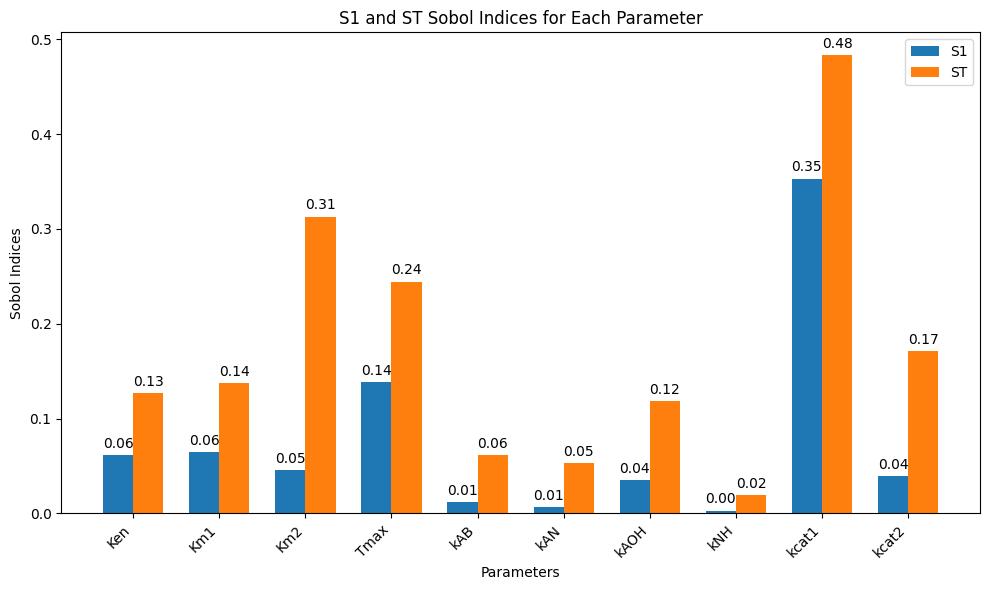

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_mean_by_parameter is the DataFrame with mean S1 and ST values for each parameter
parameters = df_mean_by_parameter['parameter']
S1_values = df_mean_by_parameter['S1']
ST_values = df_mean_by_parameter['ST']

# Set up the bar chart
x = np.arange(len(parameters))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot S1 and ST as grouped bar charts
bars1 = ax.bar(x - width/2, S1_values, width, label='S1')
bars2 = ax.bar(x + width/2, ST_values, width, label='ST')

# Add some labels and titles
ax.set_xlabel('Parameters')
ax.set_ylabel('Sobol Indices')
ax.set_title('S1 and ST Sobol Indices for Each Parameter')
ax.set_xticks(x)
ax.set_xticklabels(parameters, rotation=45, ha="right")
ax.legend()

# Add value labels on top of bars (optional)
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout to prevent clipping
fig.tight_layout()
plt.savefig(os.path.join(generalized_output_dir, f'generalized_mean_S1_ST.png'))
# Show the plot
plt.show()
